In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'xgboost'

In [1]:
from flask.json import jsonify
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

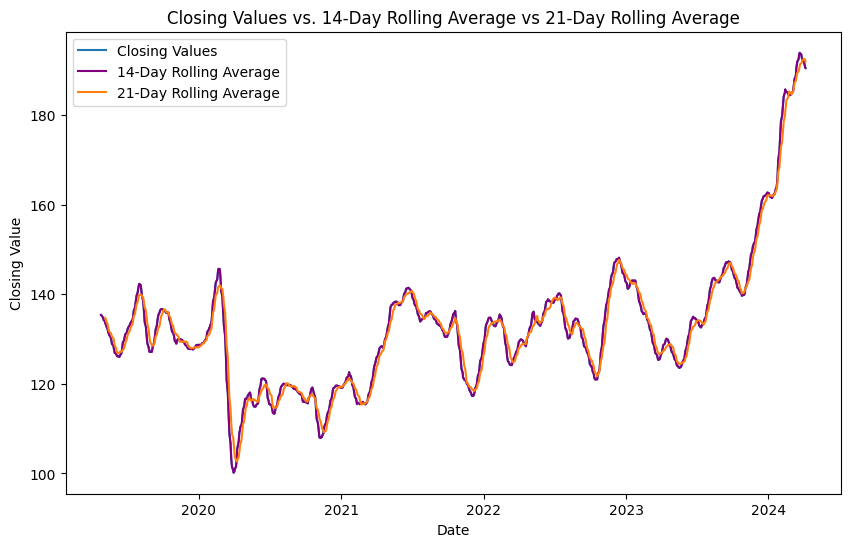

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("ticker_data.csv")

# Set the "date" column as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


df_close = df["close"]

# Calculate the rolling average for every 10 days
rolling_avg = df_close.rolling(window=10).mean()
# 30 days
rolling_avg_21 = df_close.rolling(window=21).mean()
rolling_avg_14 =  df_close.rolling(window=14).mean()

df_close= df_close.rolling(window=14).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_close.index, df_close, label='Closing Values')
plt.plot(rolling_avg.index, rolling_avg_14, label='14-Day Rolling Average' ,color ="purple")
plt.plot(rolling_avg_21.index, rolling_avg_21, label='21-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Closing Value')
plt.title('Closing Values vs. 14-Day Rolling Average vs 21-Day Rolling Average')
plt.legend()
plt.show()


In [19]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(df_close) * .95 ))

training_data_len

1196

In [20]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler


df_close_values = df_close.values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_close_values.reshape(-1, 1))

scaled_data

array([[       nan],
       [       nan],
       [       nan],
       ...,
       [0.96925596],
       [0.96507501],
       [0.96360521]])

In [37]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[~np.isnan(scaled_data[:, 0])][:training_data_len]  # Exclude NaN values

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(14, len(train_data)):
    x_train.append(train_data[i-14:i, 0])
    y_train.append(train_data[i, 0])
    # if i<= 61:

        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(y_train.shape,x_train.shape )
print(y_train,x_train )

(1182,) (1182, 14, 1)
[0.33108674 0.32764451 0.32389765 ... 0.69035108 0.70088341 0.72340263] [[[0.37554642]
  [0.37238596]
  [0.37104562]
  ...
  [0.34159622]
  [0.33676034]
  [0.33368365]]

 [[0.37238596]
  [0.37104562]
  [0.36925596]
  ...
  [0.33676034]
  [0.33368365]
  [0.33108674]]

 [[0.37104562]
  [0.36925596]
  [0.36620212]
  ...
  [0.33368365]
  [0.33108674]
  [0.32764451]]

 ...

 [[0.66563857]
  [0.66212779]
  [0.66002589]
  ...
  [0.66792324]
  [0.67381007]
  [0.68087731]]

 [[0.66212779]
  [0.66002589]
  [0.65717006]
  ...
  [0.67381007]
  [0.68087731]
  [0.69035108]]

 [[0.66002589]
  [0.65717006]
  [0.65633996]
  ...
  [0.68087731]
  [0.69035108]
  [0.70088341]]]


In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10


c:\Users\mabro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0297
Epoch 2/10
 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0011

In [40]:

test_data = scaled_data[training_data_len - 14: , :]


# print(test_data)



# Create the data sets x_test and y_test
x_test = []
y_test = df_close_values[training_data_len:]
for i in range(14, len(test_data)):
    x_test.append(test_data[i-14:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)
# print(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
# print(test_data)
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# print(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


16.430965910178056

In [42]:
from sklearn.metrics import r2_score
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# Calculate R2 score
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

percentage_accuracy = r2 * 100

print("Percentage Accuracy:", percentage_accuracy)

Root Mean Squared Error (RMSE): 16.430965910178056
R-squared (R2) Score: 0.6364671031384551
Percentage Accuracy: 63.64671031384551


C:\Users\mabro\AppData\Local\Temp\ipykernel_15120\3105816501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


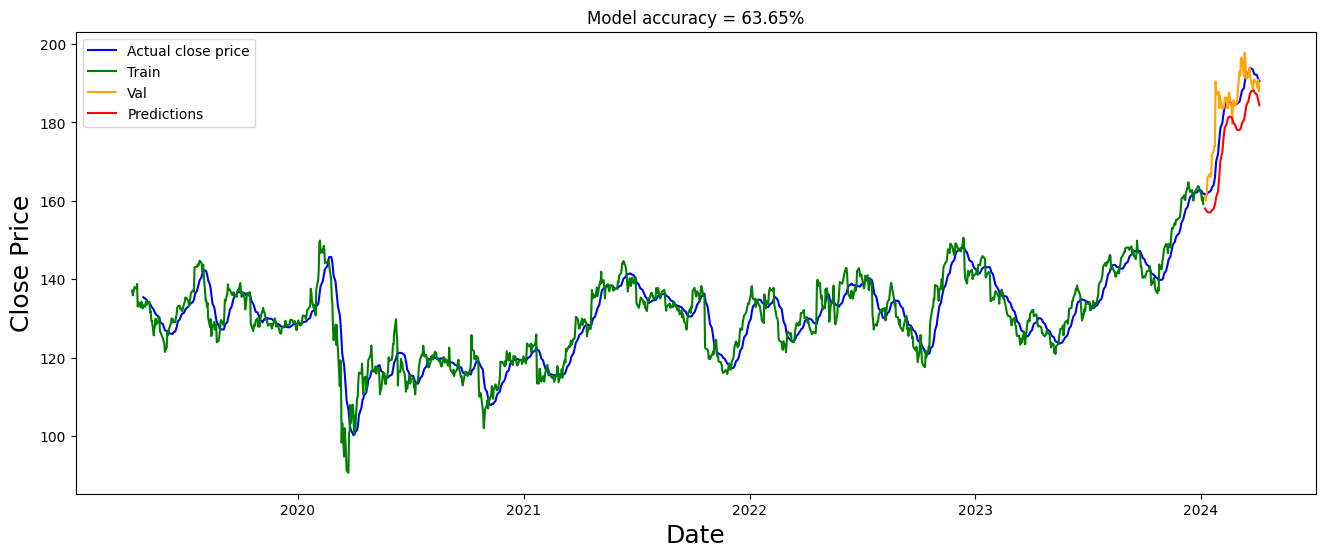

In [43]:
# Plot the data
train = df[:training_data_len]
valid = df[training_data_len:]

valid['Predictions'] = predictions
valid
predictions_df = pd.DataFrame(predictions, index=valid.index, columns=['Predictions'])

percentage_accuracy_str = "{:.2f}".format(percentage_accuracy)
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model accuracy = {}%'.format(percentage_accuracy_str))

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df_close,color='blue', label="Actual close price")
plt.plot(train['close'], label="Train",color='green')
plt.plot(valid['close'],label="Val", color='orange',)
plt.plot(valid['Predictions'],label="Predictions", color='red')
plt.legend(loc='upper left')
plt.show()

<AxesSubplot:xlabel='date'>

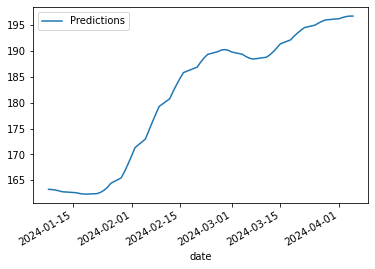

In [124]:
predictions_df.plot()

In [135]:
# predicting for next 14 days
# most recent 21 days of data
# 1d arrau
recent_data = df_close[-21:].values
# reshape for minmax to 2d array 
recent_data = recent_data.reshape(-1, 1)  


# scalling
scaled_recent_data = scaler.transform(recent_data)

# reshape for model
x_input = scaled_recent_data.reshape((1, 21, 1))

# predict for next 14 days
predicted_prices = []

for _ in range(30):
    # Predict the close price for the next day
    next_day_prediction = model.predict(x_input)
    
    # Append the prediction to the list of predicted prices
    predicted_prices.append(next_day_prediction[0, 0])
    
    # Update the input data for the next prediction
    x_input = np.append(x_input[:, 1:, :], np.expand_dims(next_day_prediction, axis=1), axis=1)



# Inverse scale the predicted prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Print the predicted close prices for the next 14 days
print("Predicted Close Prices for the Next 14 Days:")
for i, price in enumerate(predicted_prices, 1):
    print(f"Day {i}: ${price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

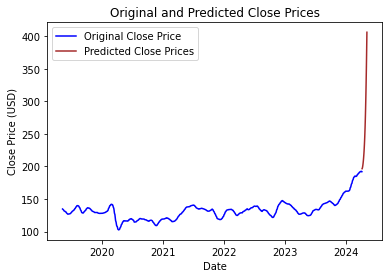

In [136]:
import matplotlib.pyplot as plt

# Plotting the original close prices
plt.plot(df_close.index, df_close, color='blue', label='Original Close Price')

# Plotting the predicted close prices for the next 14 days
next_14_days_index = pd.date_range(start=df_close.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(next_14_days_index, predicted_prices, color='brown', linestyle='-', label='Predicted Close Prices')
# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Original and Predicted Close Prices')
plt.legend()

# Show plot
plt.show()
